In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import rioxarray as rxr
from datetime import datetime, date
import json
from xgrads import open_CtlDataset
import geopandas as gpd
import requests
import hydrofunctions as hf
import matplotlib.pyplot as plt
import folium 
%matplotlib inline

In [9]:
# Choose a domain
domain = 'BEAU'

# calibration dates
# start calibration date    
st_dtcal = '2011-10-01'
# end calibration date
ed_dtcal = '2018-09-30'

# paths 
SMpath = '/nfs/attic/dfh/2020_NPRB/domain_'+domain+'/snowmodel2023_cfsv2/'
#hydroflow path 
HFpath = '/nfs/attic/dfh/2020_NPRB/domain_'+domain+'/snowmodel2023_cfsv2/hydroflowcal1/'
# data location
datapath = '/nfs/attic/dfh/2020_NPRB/data/'
# stream gauge data
flowpath = datapath+'stream_gage/'+domain+'/'
# calibration disgharge data
flowdatacal = flowpath+domain+'_discharge_cfs_'+st_dtcal+'_'+ed_dtcal+'.csv'
# calibration station gdf
flowstncal = flowpath+domain+'_gage_meta_'+st_dtcal+'_'+ed_dtcal+'.geojson'
# calibration station gdf projected
flowstnprojcal = flowpath+domain+'_gage_meta_proj_'+st_dtcal+'_'+ed_dtcal+'.geojson'

#path to NPRB domains
domains_resp = requests.get("https://raw.githubusercontent.com/NPRB/02_preprocess_python/main/NPRB_domains.json")
domains = domains_resp.json()

In [3]:
stnproj = gpd.read_file(flowstnprojcal)

This notebook requires manual examination of each station to retrieve the i, j pair from the hydroflow data. Manual corrections are often required to match the station location to the stream channel that was determined in hydroflow. 

# find i j pair for each station 

Need to find the i j pair for each of the gage locations to extract hydroflow output. To do this - each station locaiton needs to be compared to the disgarge output to make sure it align with the computed river network. 

In [4]:
#use topo to get spatial info
# SM forcing files 
SMdatapath = datapath+'SMinputs/'+domain+'/'
# dem ascii file
demasc = SMdatapath+domain+'_dem.asc'

topo = rxr.open_rasterio(demasc)

In [10]:
#hydroflow discharge data using pixel centers 
ctlFile = HFpath+'disc_s10_f1.ctl'

q = open_CtlDataset(ctlFile)
q=q.assign_coords({"lat": np.flipud(topo.y.values)-int(domains[domain]['cellsize']),"lon": topo.x.values-int(domains[domain]['cellsize'])})

q

,Array,Chunk
Bytes,6.13 GiB,2.46 MiB
Shape,"(2557, 1, 496, 1298)","(1, 1, 496, 1298)"
Count,2557 Tasks,2557 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,6.13 GiB,2.46 MiB
Shape,"(2557, 1, 496, 1298)","(1, 1, 496, 1298)"
Count,2557 Tasks,2557 Chunks
Type,float32,numpy.ndarray


In [11]:
# domain shapefile
shp = gpd.read_file('/nfs/attic/dfh/2020_NPRB/data/gis/'+domain+'/'+domain+'.json')
shpproj = shp.to_crs(stnproj.crs)

<Axes: title={'center': 'lev = 1.0'}, xlabel='lon', ylabel='lat'>

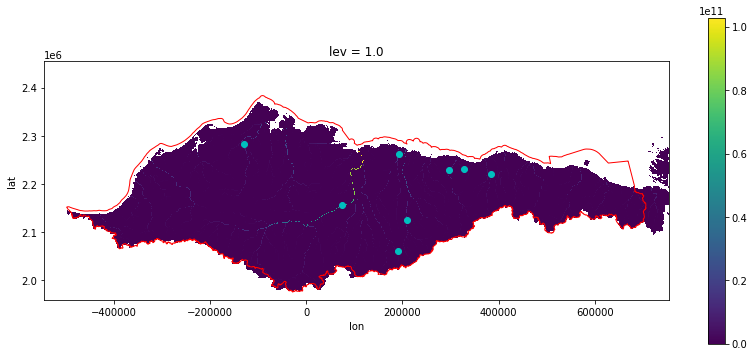

In [12]:
qsum = q.slow.isel(lev=0).sum('time')+q.fast.isel(lev=0).sum('time')

fig, ax = plt.subplots(figsize=(14,6))

qsum.where(qsum>0).plot(vmin=0,ax=ax)
stnproj.plot(ax=ax,c='c')
shpproj.plot(ax=ax,facecolor='None',edgecolor='r')

In [13]:
# Add custom base maps to folium
basemaps = {
    'Google Maps': folium.TileLayer(
        tiles = 'https://mt1.google.com/vt/lyrs=m&x={x}&y={y}&z={z}',
        attr = 'Google',
        name = 'Google Maps',
        overlay = True,
        control = True
    ),
    'Google Satellite': folium.TileLayer(
        tiles = 'https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}',
        attr = 'Google',
        name = 'Google Satellite',
        overlay = True,
        control = True
    ),
    'Google Terrain': folium.TileLayer(
        tiles = 'https://mt1.google.com/vt/lyrs=p&x={x}&y={y}&z={z}',
        attr = 'Google',
        name = 'Google Terrain',
        overlay = True,
        control = True
    ),
    'Google Satellite Hybrid': folium.TileLayer(
        tiles = 'https://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}',
        attr = 'Google',
        name = 'Google Satellite',
        overlay = True,
        control = True
    ),
    'Esri Satellite': folium.TileLayer(
        tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
        attr = 'Esri',
        name = 'Esri Satellite',
        overlay = True,
        control = True
    )
}

In [14]:
stnproj

,agency_cd,site_no,station_nm,site_tp_cd,lat_va,long_va,dec_lat_va,dec_long_va,coord_meth_cd,coord_acy_cd,...,reliability_cd,gw_file_cd,nat_aqfr_cd,aqfr_cd,aqfr_type_cd,well_depth_va,hole_depth_va,depth_src_cd,project_no,geometry
0,USGS,15803000,MEADE R AT ATKASUK AK,ST,702945.0,1572333.0,70.495376,-157.395848,M,S,...,None,NYNNNNNN,None,None,None,None,None,None,None,POINT (-129053.158 2282397.475)
1,USGS,15875000,COLVILLE R AT UMIAT AK,ST,692137.8,1520721.7,69.360500,-152.122694,Y,D,...,None,NYNNNNNN,None,None,None,None,None,None,None,POINT (74884.972 2155626.519)
2,USGS,15896000,KUPARUK R NR DEADHORSE AK,ST,701654.0,1485735.0,70.281385,-148.962786,M,T,...,None,NNNNNNNN,None,None,None,None,None,None,None,POINT (193105.171 2263000.626)
3,USGS,15905100,ATIGUN R BL GALBRAITH LK NR PUMP STATION 4 AK,ST,682708.0,1492224.0,68.452222,-149.373333,Y,S,...,None,None,None,None,None,None,None,None,None,POINT (191402.544 2061090.423)
4,USGS,15908000,SAGAVANIRKTOK R NR PUMP STA 3 AK,ST,690057.0,1484904.0,69.015833,-148.817778,N,5,...,None,NYNNNNNN,None,None,None,None,None,None,None,POINT (209493.473 2124788.351)
5,USGS,15955000,CANNING R AB STAINES R NR DEADHORSE AK,ST,695255.0,1462309.0,69.881705,-146.388699,G,S,...,None,Y,None,None,None,None,None,None,None,POINT (296437.161 2228856.346)
6,USGS,15960000,TAMAYARIAK R NR KAKTOVIK AK,ST,695155.0,1453534.0,69.865056,-145.595592,G,S,...,None,Y,None,None,None,None,None,None,None,POINT (327399.685 2230767.193)
7,USGS,15980000,HULAHULA R NR KAKTOVIK AK,ST,694214.0,1441154.0,69.703686,-144.201089,M,S,...,C,None,None,None,None,None,None,None,None,POINT (383962.332 2220680.218)


In [15]:
m = folium.Map(tiles='Stamen terrain')
for idx, row in stnproj.iterrows():
    folium.Marker(location=[row['dec_lat_va'], row['dec_long_va']], 
                  icon=folium.Icon(color='blue'),
                  popup="</br> Gage#: {0} </b> Gage name: {1}".format(
                      row['site_no'], row['station_nm'])
                 ).add_to(m)

# Set the map extent (bounds) to the extent of the sites
m.fit_bounds(m.get_bounds())

basemaps['Google Satellite'].add_to(m)

m

# BEAU stations for cal
['15875000','15896000','15908000','15803000']

# 15803000

In [120]:
i=0
stnproj.site_no[i]

'15803000'

<Axes: title={'center': 'lev = 1.0'}, xlabel='lon', ylabel='lat'>

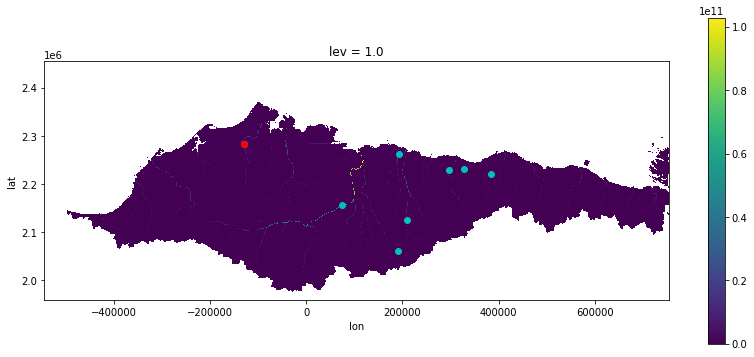

In [121]:
fig, ax = plt.subplots(figsize=(14,6))

qsum.where(qsum>0).plot(vmin=0,ax=ax)
stnproj.plot(ax=ax,c='c')
stnproj.where(stnproj.site_no == stnproj.site_no[i]).plot(ax=ax,c='r')

Station # = 15803000


(-137500.0, -121500.0)

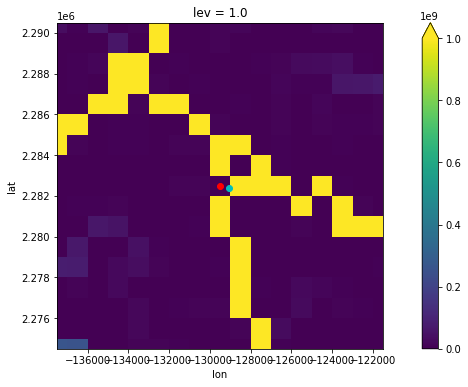

In [122]:
print('Station # = '+ stnproj.iloc[i].site_no)
slow = q.slow.sel(lon=stnproj.iloc[i].geometry.x, lat=stnproj.iloc[i].geometry.y, lev=1.0,method='nearest')
fast = q.fast.sel(lon=stnproj.iloc[i].geometry.x, lat=stnproj.iloc[i].geometry.y, lev=1.0,method='nearest')
# dataframe 
dftest = pd.DataFrame({'x':[slow.lon.values.tolist()], 'y':[slow.lat.values.tolist()]})
# geodataframe
gdftest = gpd.GeoDataFrame(dftest,geometry=gpd.points_from_xy(dftest.x, dftest.y),crs=domains[domain]['mod_proj'])

fig, ax = plt.subplots(figsize=(14,6))

qsum.where(qsum>0).plot(vmin=0,vmax=1e9,ax=ax)
stnproj.plot(ax=ax,c='c')
gdftest.plot(ax=ax,c='r')
#gdftest2.plot(ax=ax,c='g')
plt.ylim([dftest.y.values[0]-8000,dftest.y.values[0]+8000])
plt.xlim([dftest.x.values[0]-8000,dftest.x.values[0]+8000])

In [123]:
yidx = int(np.where(q.lat == slow.lat)[0])
xidx = int(np.where(q.lon == slow.lon)[0])
print('yidx = ', yidx)
print('xidx = ', xidx)


yidx =  323
xidx =  414


(-137500.0, -121500.0)

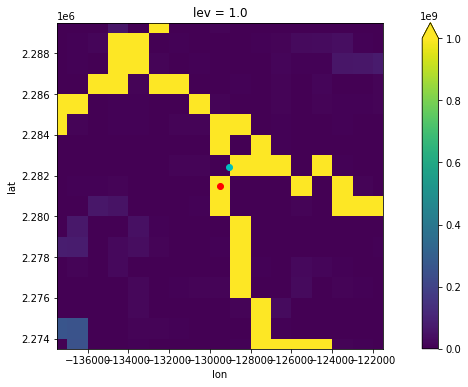

In [124]:
yidx = int(np.where(q.lat == slow.lat)[0]-1)
xidx = int(np.where(q.lon == slow.lon)[0])
# dataframe 
dftest = pd.DataFrame({'x':[q.lon.isel(lon=xidx).values.tolist()], 'y':[q.lat.isel(lat=yidx).values.tolist()]})
# geodataframe
gdftest = gpd.GeoDataFrame(dftest,geometry=gpd.points_from_xy(dftest.x, dftest.y),crs=domains[domain]['mod_proj'])

fig, ax = plt.subplots(figsize=(14,6))

qsum.where(qsum>0).plot(vmin=0,vmax=1e9,ax=ax)
stnproj.plot(ax=ax,c='c')
gdftest.plot(ax=ax,c='r')
#gdftest2.plot(ax=ax,c='g')
plt.ylim([dftest.y.values[0]-8000,dftest.y.values[0]+8000])
plt.xlim([dftest.x.values[0]-8000,dftest.x.values[0]+8000])

In [125]:
print('yidx fixed = ', yidx)
print('xidx fixed = ', xidx)

yidx fixed =  322
xidx fixed =  414


In [126]:
m = folium.Map(tiles='Stamen terrain')
for idx, row in stnproj.iterrows():
    folium.Marker(location=[row['dec_lat_va'], row['dec_long_va']], 
                  icon=folium.Icon(color='blue'),
                  popup="</br> Gage#: {0} </b> Gage name: {1}".format(
                      row['site_no'], row['station_nm'])
                 ).add_to(m)
folium.Marker(location=[gdftest.to_crs('epsg:4326').geometry.y.values[0], gdftest.to_crs('epsg:4326').geometry.x.values[0]], 
              icon=folium.Icon(color='red'),
              popup="</br> Gage#: {0} </b> Gage name: {1}".format(
                  row['site_no'], row['station_nm'])
             ).add_to(m)

# Set the map extent (bounds) to the extent of the sites
m.fit_bounds(m.get_bounds())

basemaps['Google Satellite'].add_to(m)

m

In [127]:
#indicies to save out
xidx1 = int(xidx)
yidx1 = int(yidx)

# 15875000

In [128]:
i=1
stnproj.site_no[i]

'15875000'

<Axes: title={'center': 'lev = 1.0'}, xlabel='lon', ylabel='lat'>

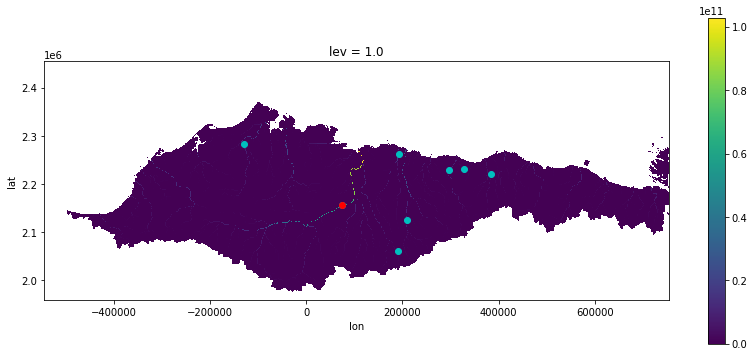

In [68]:
fig, ax = plt.subplots(figsize=(14,6))

qsum.where(qsum>0).plot(vmin=0,ax=ax)
stnproj.plot(ax=ax,c='c')
stnproj.where(stnproj.site_no == stnproj.site_no[i]).plot(ax=ax,c='r')

Station # = 15875000


(62500.0, 86500.0)

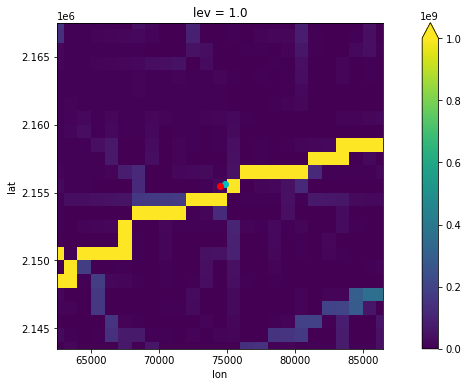

In [129]:
print('Station # = '+ stnproj.iloc[i].site_no)
slow = q.slow.sel(lon=stnproj.iloc[i].geometry.x, lat=stnproj.iloc[i].geometry.y, lev=1.0,method='nearest')
fast = q.fast.sel(lon=stnproj.iloc[i].geometry.x, lat=stnproj.iloc[i].geometry.y, lev=1.0,method='nearest')
# dataframe 
dftest = pd.DataFrame({'x':[slow.lon.values.tolist()], 'y':[slow.lat.values.tolist()]})
# geodataframe
gdftest = gpd.GeoDataFrame(dftest,geometry=gpd.points_from_xy(dftest.x, dftest.y),crs=domains[domain]['mod_proj'])

fig, ax = plt.subplots(figsize=(14,6))

qsum.where(qsum>0).plot(vmin=0,vmax=1e9,ax=ax)
stnproj.plot(ax=ax,c='c')
gdftest.plot(ax=ax,c='r')
#gdftest2.plot(ax=ax,c='g')
plt.ylim([dftest.y.values[0]-12000,dftest.y.values[0]+12000])
plt.xlim([dftest.x.values[0]-12000,dftest.x.values[0]+12000])

In [130]:
yidx = int(np.where(q.lat == slow.lat)[0])
xidx = int(np.where(q.lon == slow.lon)[0])
print('yidx = ', yidx)
print('xidx = ', xidx)

yidx =  196
xidx =  618


(67500.0, 83500.0)

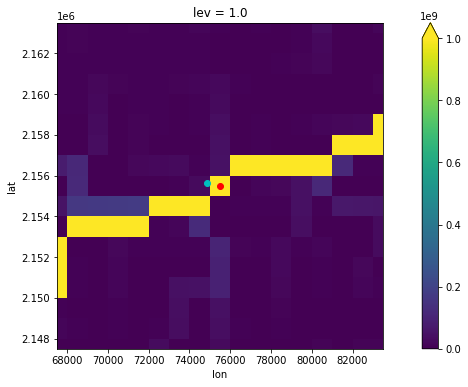

In [131]:
yidx = int(np.where(q.lat == slow.lat)[0])
xidx = int(np.where(q.lon == slow.lon)[0]+1)
# dataframe 
dftest = pd.DataFrame({'x':[q.lon.isel(lon=xidx).values.tolist()], 'y':[q.lat.isel(lat=yidx).values.tolist()]})
# geodataframe
gdftest = gpd.GeoDataFrame(dftest,geometry=gpd.points_from_xy(dftest.x, dftest.y),crs=domains[domain]['mod_proj'])

fig, ax = plt.subplots(figsize=(14,6))

qsum.where(qsum>0).plot(vmin=0,vmax=1e9,ax=ax)
stnproj.plot(ax=ax,c='c')
gdftest.plot(ax=ax,c='r')
#gdftest2.plot(ax=ax,c='g')
plt.ylim([dftest.y.values[0]-8000,dftest.y.values[0]+8000])
plt.xlim([dftest.x.values[0]-8000,dftest.x.values[0]+8000])

In [132]:
print('yidx fixed = ', yidx)
print('xidx fixed = ', xidx)

yidx fixed =  196
xidx fixed =  619


In [73]:
m = folium.Map(tiles='Stamen terrain')
for idx, row in stnproj.iterrows():
    folium.Marker(location=[row['dec_lat_va'], row['dec_long_va']], 
                  icon=folium.Icon(color='blue'),
                  popup="</br> Gage#: {0} </b> Gage name: {1}".format(
                      row['site_no'], row['station_nm'])
                 ).add_to(m)
folium.Marker(location=[gdftest.to_crs('epsg:4326').geometry.y.values[0], gdftest.to_crs('epsg:4326').geometry.x.values[0]], 
              icon=folium.Icon(color='red'),
              popup="</br> Gage#: {0} </b> Gage name: {1}".format(
                  row['site_no'], row['station_nm'])
             ).add_to(m)

# Set the map extent (bounds) to the extent of the sites
m.fit_bounds(m.get_bounds())

basemaps['Google Satellite'].add_to(m)

m

In [133]:
#indicies to save out
xidx2 = int(xidx)
yidx2 = int(yidx)

# 15896000

In [134]:
i=2
stnproj.site_no[i]

'15896000'

<Axes: title={'center': 'lev = 1.0'}, xlabel='lon', ylabel='lat'>

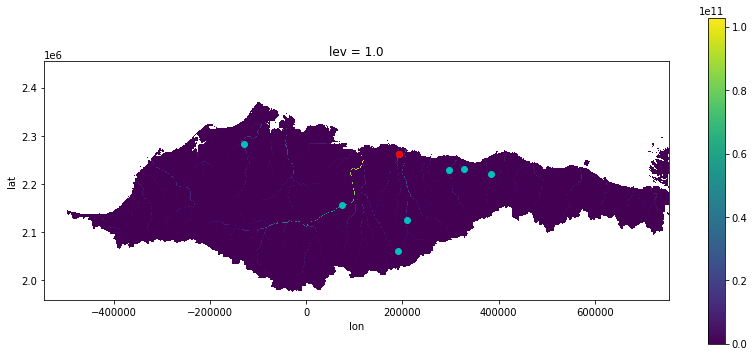

In [76]:
fig, ax = plt.subplots(figsize=(14,6))

qsum.where(qsum>0).plot(vmin=0,ax=ax)
stnproj.plot(ax=ax,c='c')
stnproj.where(stnproj.site_no == stnproj.site_no[i]).plot(ax=ax,c='r')

Station # = 15896000


(188500.0, 198500.0)

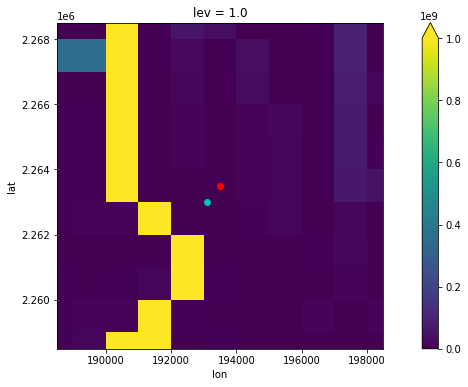

In [135]:
print('Station # = '+ stnproj.iloc[i].site_no)
slow = q.slow.sel(lon=stnproj.iloc[i].geometry.x, lat=stnproj.iloc[i].geometry.y, lev=1.0,method='nearest')
fast = q.fast.sel(lon=stnproj.iloc[i].geometry.x, lat=stnproj.iloc[i].geometry.y, lev=1.0,method='nearest')
# dataframe 
dftest = pd.DataFrame({'x':[slow.lon.values.tolist()], 'y':[slow.lat.values.tolist()]})
# geodataframe
gdftest = gpd.GeoDataFrame(dftest,geometry=gpd.points_from_xy(dftest.x, dftest.y),crs=domains[domain]['mod_proj'])

fig, ax = plt.subplots(figsize=(14,6))

qsum.where(qsum>0).plot(vmin=0,vmax=1e9,ax=ax)
stnproj.plot(ax=ax,c='c')
gdftest.plot(ax=ax,c='r')
#gdftest2.plot(ax=ax,c='g')
plt.ylim([dftest.y.values[0]-5000,dftest.y.values[0]+5000])
plt.xlim([dftest.x.values[0]-5000,dftest.x.values[0]+5000])

In [136]:
yidx = int(np.where(q.lat == slow.lat)[0])
xidx = int(np.where(q.lon == slow.lon)[0])
print('yidx = ', yidx)
print('xidx = ', xidx)

yidx =  304
xidx =  737


(183500.0, 199500.0)

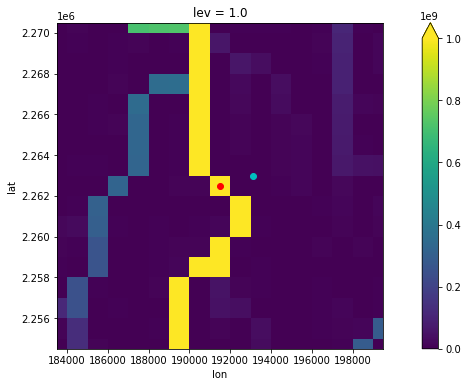

In [137]:
yidx = int(np.where(q.lat == slow.lat)[0]-1)
xidx = int(np.where(q.lon == slow.lon)[0]-2)
# dataframe 
dftest = pd.DataFrame({'x':[q.lon.isel(lon=xidx).values.tolist()], 'y':[q.lat.isel(lat=yidx).values.tolist()]})
# geodataframe
gdftest = gpd.GeoDataFrame(dftest,geometry=gpd.points_from_xy(dftest.x, dftest.y),crs=domains[domain]['mod_proj'])

fig, ax = plt.subplots(figsize=(14,6))

qsum.where(qsum>0).plot(vmin=0,vmax=1e9,ax=ax)
stnproj.plot(ax=ax,c='c')
gdftest.plot(ax=ax,c='r')
#gdftest2.plot(ax=ax,c='g')
plt.ylim([dftest.y.values[0]-8000,dftest.y.values[0]+8000])
plt.xlim([dftest.x.values[0]-8000,dftest.x.values[0]+8000])

In [138]:
print('yidx fixed = ', yidx)
print('xidx fixed = ', xidx)

yidx fixed =  303
xidx fixed =  735


In [79]:
m = folium.Map(tiles='Stamen terrain')
for idx, row in stnproj.iterrows():
    folium.Marker(location=[row['dec_lat_va'], row['dec_long_va']], 
                  icon=folium.Icon(color='blue'),
                  popup="</br> Gage#: {0} </b> Gage name: {1}".format(
                      row['site_no'], row['station_nm'])
                 ).add_to(m)
folium.Marker(location=[gdftest.to_crs('epsg:4326').geometry.y.values[0], gdftest.to_crs('epsg:4326').geometry.x.values[0]], 
              icon=folium.Icon(color='red'),
              popup="</br> Gage#: {0} </b> Gage name: {1}".format(
                  row['site_no'], row['station_nm'])
             ).add_to(m)

# Set the map extent (bounds) to the extent of the sites
m.fit_bounds(m.get_bounds())

basemaps['Google Satellite'].add_to(m)

m

In [139]:
#indicies to save out
xidx3 = int(xidx)
yidx3 = int(yidx)

# 15905100

In [140]:
i=3
stnproj.site_no[i]

'15905100'

<Axes: title={'center': 'lev = 1.0'}, xlabel='lon', ylabel='lat'>

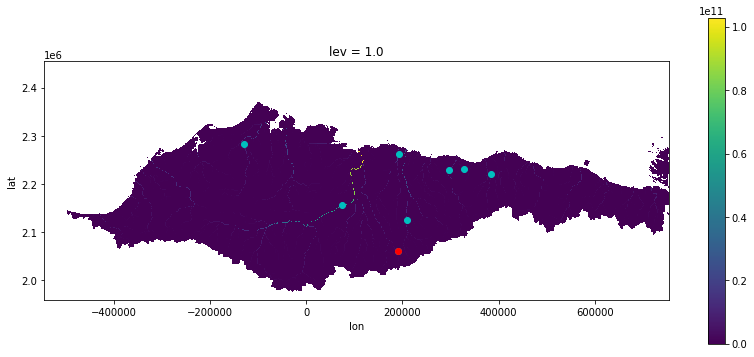

In [86]:
fig, ax = plt.subplots(figsize=(14,6))

qsum.where(qsum>0).plot(vmin=0,ax=ax)
stnproj.plot(ax=ax,c='c')
stnproj.where(stnproj.site_no == stnproj.site_no[i]).plot(ax=ax,c='r')

Station # = 15905100


(183500.0, 199500.0)

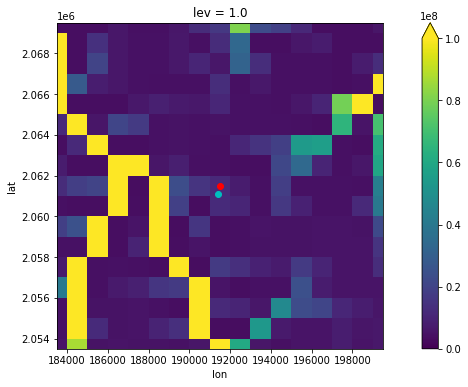

In [141]:
print('Station # = '+ stnproj.iloc[i].site_no)
slow = q.slow.sel(lon=stnproj.iloc[i].geometry.x, lat=stnproj.iloc[i].geometry.y, lev=1.0,method='nearest')
fast = q.fast.sel(lon=stnproj.iloc[i].geometry.x, lat=stnproj.iloc[i].geometry.y, lev=1.0,method='nearest')
# dataframe 
dftest = pd.DataFrame({'x':[slow.lon.values.tolist()], 'y':[slow.lat.values.tolist()]})
# geodataframe
gdftest = gpd.GeoDataFrame(dftest,geometry=gpd.points_from_xy(dftest.x, dftest.y),crs=domains[domain]['mod_proj'])

fig, ax = plt.subplots(figsize=(14,6))

qsum.where(qsum>0).plot(vmin=0,vmax=1e8,ax=ax)
stnproj.plot(ax=ax,c='c')
gdftest.plot(ax=ax,c='r')
#gdftest2.plot(ax=ax,c='g')
plt.ylim([dftest.y.values[0]-8000,dftest.y.values[0]+8000])
plt.xlim([dftest.x.values[0]-8000,dftest.x.values[0]+8000])

In [142]:
yidx = int(np.where(q.lat == slow.lat)[0])
xidx = int(np.where(q.lon == slow.lon)[0])
print('yidx = ', yidx)
print('xidx = ', xidx)

yidx =  102
xidx =  735


(183500.0, 198500.0)

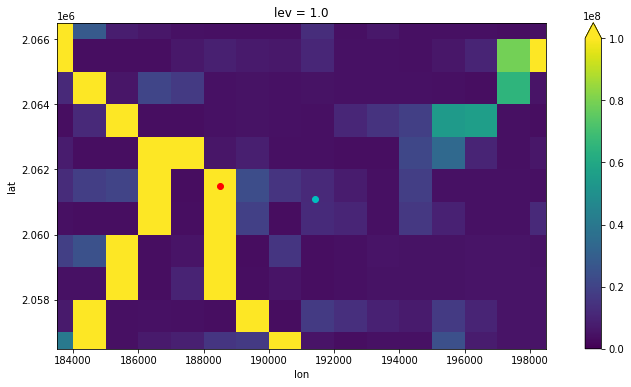

In [143]:
yidx = int(np.where(q.lat == slow.lat)[0])
xidx = int(np.where(q.lon == slow.lon)[0]-3)
# dataframe 
dftest = pd.DataFrame({'x':[q.lon.isel(lon=xidx).values.tolist()], 'y':[q.lat.isel(lat=yidx).values.tolist()]})
# geodataframe
gdftest = gpd.GeoDataFrame(dftest,geometry=gpd.points_from_xy(dftest.x, dftest.y),crs=domains[domain]['mod_proj'])

fig, ax = plt.subplots(figsize=(14,6))

qsum.where(qsum>0).plot(vmin=0,vmax=1e8,ax=ax)
stnproj.plot(ax=ax,c='c')
gdftest.plot(ax=ax,c='r')
#gdftest2.plot(ax=ax,c='g')
plt.ylim([dftest.y.values[0]-5000,dftest.y.values[0]+5000])
plt.xlim([dftest.x.values[0]-5000,dftest.x.values[0]+10000])

In [144]:
print('yidx fixed = ', yidx)
print('xidx fixed = ', xidx)

yidx fixed =  102
xidx fixed =  732


In [90]:
m = folium.Map(tiles='Stamen terrain')
for idx, row in stnproj.iterrows():
    folium.Marker(location=[row['dec_lat_va'], row['dec_long_va']], 
                  icon=folium.Icon(color='blue'),
                  popup="</br> Gage#: {0} </b> Gage name: {1}".format(
                      row['site_no'], row['station_nm'])
                 ).add_to(m)
folium.Marker(location=[gdftest.to_crs('epsg:4326').geometry.y.values[0], gdftest.to_crs('epsg:4326').geometry.x.values[0]], 
              icon=folium.Icon(color='red'),
              popup="</br> Gage#: {0} </b> Gage name: {1}".format(
                  row['site_no'], row['station_nm'])
             ).add_to(m)

# Set the map extent (bounds) to the extent of the sites
m.fit_bounds(m.get_bounds())

basemaps['Google Satellite'].add_to(m)

m

In [145]:
#indicies to save out
xidx4 = int(xidx)
yidx4 = int(yidx)

# 15908000

In [146]:
i=4
stnproj.site_no[i]

'15908000'

<Axes: title={'center': 'lev = 1.0'}, xlabel='lon', ylabel='lat'>

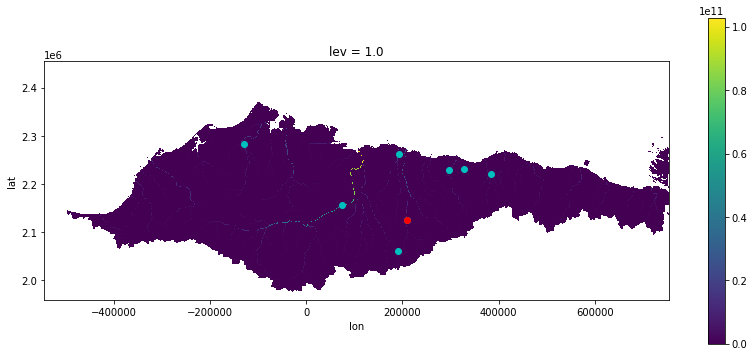

In [99]:
fig, ax = plt.subplots(figsize=(14,6))

qsum.where(qsum>0).plot(vmin=0,ax=ax)
stnproj.plot(ax=ax,c='c')
stnproj.where(stnproj.site_no == stnproj.site_no[i]).plot(ax=ax,c='r')

Station # = 15908000


(201500.0, 217500.0)

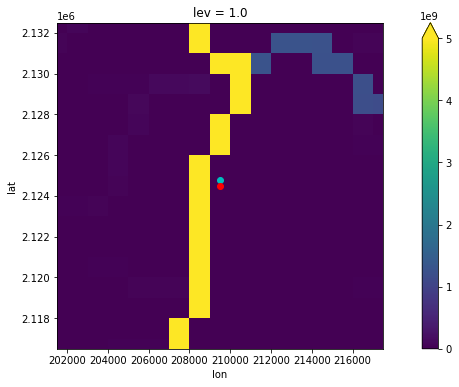

In [147]:
print('Station # = '+ stnproj.iloc[i].site_no)
slow = q.slow.sel(lon=stnproj.iloc[i].geometry.x, lat=stnproj.iloc[i].geometry.y, lev=1.0,method='nearest')
fast = q.fast.sel(lon=stnproj.iloc[i].geometry.x, lat=stnproj.iloc[i].geometry.y, lev=1.0,method='nearest')
# dataframe 
dftest = pd.DataFrame({'x':[slow.lon.values.tolist()], 'y':[slow.lat.values.tolist()]})
# geodataframe
gdftest = gpd.GeoDataFrame(dftest,geometry=gpd.points_from_xy(dftest.x, dftest.y),crs=domains[domain]['mod_proj'])

fig, ax = plt.subplots(figsize=(14,6))

qsum.where(qsum>0).plot(vmin=0,vmax=5e9,ax=ax)
stnproj.plot(ax=ax,c='c')
gdftest.plot(ax=ax,c='r')
#gdftest2.plot(ax=ax,c='g')
plt.ylim([dftest.y.values[0]-8000,dftest.y.values[0]+8000])
plt.xlim([dftest.x.values[0]-8000,dftest.x.values[0]+8000])

In [148]:
yidx = int(np.where(q.lat == slow.lat)[0])
xidx = int(np.where(q.lon == slow.lon)[0])
print('yidx = ', yidx)
print('xidx = ', xidx)

yidx =  165
xidx =  753


(200500.0, 216500.0)

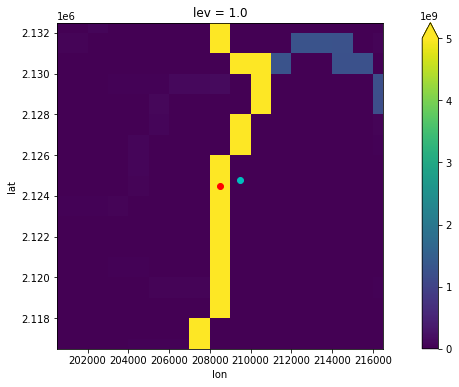

In [149]:
yidx = int(np.where(q.lat == slow.lat)[0])
xidx = int(np.where(q.lon == slow.lon)[0]-1)
# dataframe 
dftest = pd.DataFrame({'x':[q.lon.isel(lon=xidx).values.tolist()], 'y':[q.lat.isel(lat=yidx).values.tolist()]})
# geodataframe
gdftest = gpd.GeoDataFrame(dftest,geometry=gpd.points_from_xy(dftest.x, dftest.y),crs=domains[domain]['mod_proj'])

fig, ax = plt.subplots(figsize=(14,6))

qsum.where(qsum>0).plot(vmin=0,vmax=5e9,ax=ax)
stnproj.plot(ax=ax,c='c')
gdftest.plot(ax=ax,c='r')
#gdftest2.plot(ax=ax,c='g')
plt.ylim([dftest.y.values[0]-8000,dftest.y.values[0]+8000])
plt.xlim([dftest.x.values[0]-8000,dftest.x.values[0]+8000])

In [150]:
print('yidx fixed = ', yidx)
print('xidx fixed = ', xidx)

yidx fixed =  165
xidx fixed =  752


In [105]:
m = folium.Map(tiles='Stamen terrain')
for idx, row in stnproj.iterrows():
    folium.Marker(location=[row['dec_lat_va'], row['dec_long_va']], 
                  icon=folium.Icon(color='blue'),
                  popup="</br> Gage#: {0} </b> Gage name: {1}".format(
                      row['site_no'], row['station_nm'])
                 ).add_to(m)
folium.Marker(location=[gdftest.to_crs('epsg:4326').geometry.y.values[0], gdftest.to_crs('epsg:4326').geometry.x.values[0]], 
              icon=folium.Icon(color='red'),
              popup="</br> Gage#: {0} </b> Gage name: {1}".format(
                  row['site_no'], row['station_nm'])
             ).add_to(m)

# Set the map extent (bounds) to the extent of the sites
m.fit_bounds(m.get_bounds())

basemaps['Google Satellite'].add_to(m)

m

In [151]:
#indicies to save out
xidx5 = int(xidx)
yidx5 = int(yidx)

# 15955000

In [109]:
i=5
stnproj.site_no[i]

'15955000'

<AxesSubplot:title={'center':'lev = 1.0'}, xlabel='lon', ylabel='lat'>

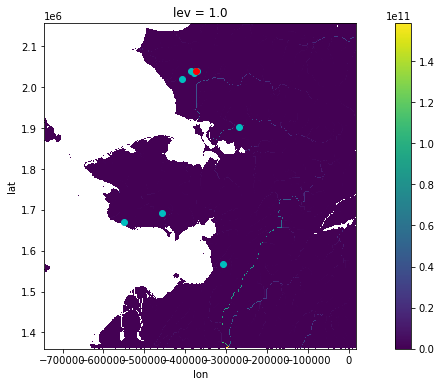

In [51]:
fig, ax = plt.subplots(figsize=(14,6))

qsum.where(qsum>0).plot(vmin=0,ax=ax)
stnproj.plot(ax=ax,c='c')
stnproj.where(stnproj.site_no == stnproj.site_no[i]).plot(ax=ax,c='r')

Station # = 15746980


(-379500.0, -369500.0)

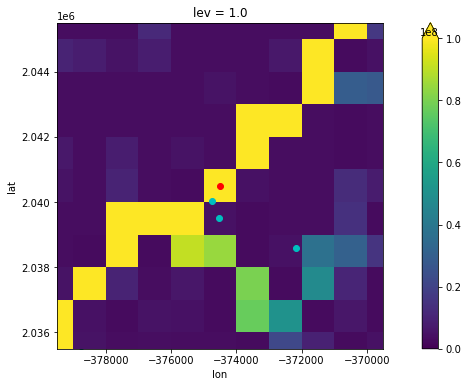

In [52]:
print('Station # = '+ stnproj.iloc[i].site_no)
slow = q.slow.sel(lon=stnproj.iloc[i].geometry.x, lat=stnproj.iloc[i].geometry.y, lev=1.0,method='nearest')
fast = q.fast.sel(lon=stnproj.iloc[i].geometry.x, lat=stnproj.iloc[i].geometry.y, lev=1.0,method='nearest')
# dataframe 
dftest = pd.DataFrame({'x':[slow.lon.values.tolist()], 'y':[slow.lat.values.tolist()]})
# geodataframe
gdftest = gpd.GeoDataFrame(dftest,geometry=gpd.points_from_xy(dftest.x, dftest.y),crs=domains[domain]['mod_proj'])

fig, ax = plt.subplots(figsize=(14,6))

qsum.where(qsum>0).plot(vmin=0,vmax=1e8,ax=ax)
stnproj.plot(ax=ax,c='c')
gdftest.plot(ax=ax,c='r')
#gdftest2.plot(ax=ax,c='g')
plt.ylim([dftest.y.values[0]-5000,dftest.y.values[0]+5000])
plt.xlim([dftest.x.values[0]-5000,dftest.x.values[0]+5000])

In [53]:
yidx = int(np.where(q.lat == slow.lat)[0])
xidx = int(np.where(q.lon == slow.lon)[0])
print('yidx = ', yidx)
print('xidx = ', xidx)

yidx =  680
xidx =  370


In [54]:
m = folium.Map(tiles='Stamen terrain')
for idx, row in stnproj.iterrows():
    folium.Marker(location=[row['dec_lat_va'], row['dec_long_va']], 
                  icon=folium.Icon(color='blue'),
                  popup="</br> Gage#: {0} </b> Gage name: {1}".format(
                      row['site_no'], row['station_nm'])
                 ).add_to(m)
folium.Marker(location=[gdftest.to_crs('epsg:4326').geometry.y.values[0], gdftest.to_crs('epsg:4326').geometry.x.values[0]], 
              icon=folium.Icon(color='red'),
              popup="</br> Gage#: {0} </b> Gage name: {1}".format(
                  row['site_no'], row['station_nm'])
             ).add_to(m)

# Set the map extent (bounds) to the extent of the sites
m.fit_bounds(m.get_bounds())

basemaps['Google Satellite'].add_to(m)

m

In [115]:
#indicies to save out
xidx6 = np.nan
yidx6 = np.nan

# 15960000

In [110]:
i=6
stnproj.site_no[i]

'15960000'

<AxesSubplot:title={'center':'lev = 1.0'}, xlabel='lon', ylabel='lat'>

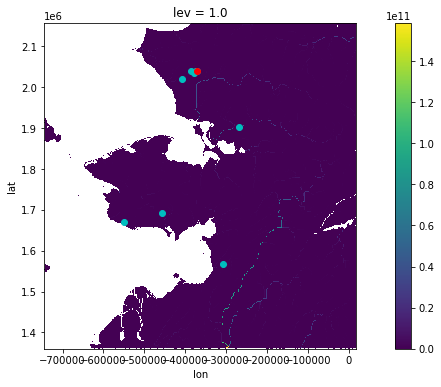

In [57]:
fig, ax = plt.subplots(figsize=(14,6))

qsum.where(qsum>0).plot(vmin=0,ax=ax)
stnproj.plot(ax=ax,c='c')
stnproj.where(stnproj.site_no == stnproj.site_no[i]).plot(ax=ax,c='r')

Station # = 15746988


(-380500.0, -364500.0)

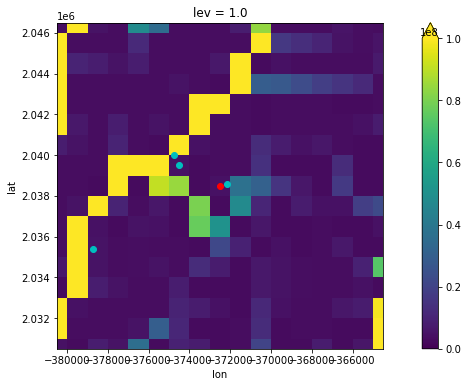

In [58]:
print('Station # = '+ stnproj.iloc[i].site_no)
slow = q.slow.sel(lon=stnproj.iloc[i].geometry.x, lat=stnproj.iloc[i].geometry.y, lev=1.0,method='nearest')
fast = q.fast.sel(lon=stnproj.iloc[i].geometry.x, lat=stnproj.iloc[i].geometry.y, lev=1.0,method='nearest')
# dataframe 
dftest = pd.DataFrame({'x':[slow.lon.values.tolist()], 'y':[slow.lat.values.tolist()]})
# geodataframe
gdftest = gpd.GeoDataFrame(dftest,geometry=gpd.points_from_xy(dftest.x, dftest.y),crs=domains[domain]['mod_proj'])

fig, ax = plt.subplots(figsize=(14,6))

qsum.where(qsum>0).plot(vmin=0,vmax=1e8,ax=ax)
stnproj.plot(ax=ax,c='c')
gdftest.plot(ax=ax,c='r')
#gdftest2.plot(ax=ax,c='g')
plt.ylim([dftest.y.values[0]-8000,dftest.y.values[0]+8000])
plt.xlim([dftest.x.values[0]-8000,dftest.x.values[0]+8000])

In [59]:
yidx = int(np.where(q.lat == slow.lat)[0])
xidx = int(np.where(q.lon == slow.lon)[0])
print('yidx = ', yidx)
print('xidx = ', xidx)

yidx =  678
xidx =  372


(-381500.0, -365500.0)

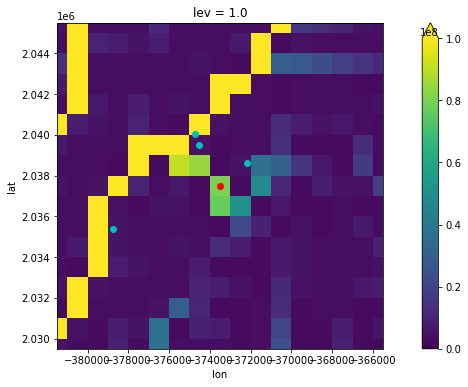

In [60]:
yidx = int(np.where(q.lat == slow.lat)[0]-1)
xidx = int(np.where(q.lon == slow.lon)[0]-1)
# dataframe 
dftest = pd.DataFrame({'x':[q.lon.isel(lon=xidx).values.tolist()], 'y':[q.lat.isel(lat=yidx).values.tolist()]})
# geodataframe
gdftest = gpd.GeoDataFrame(dftest,geometry=gpd.points_from_xy(dftest.x, dftest.y),crs=domains[domain]['mod_proj'])

fig, ax = plt.subplots(figsize=(14,6))

qsum.where(qsum>0).plot(vmin=0,vmax=1e8,ax=ax)
stnproj.plot(ax=ax,c='c')
gdftest.plot(ax=ax,c='r')
#gdftest2.plot(ax=ax,c='g')
plt.ylim([dftest.y.values[0]-8000,dftest.y.values[0]+8000])
plt.xlim([dftest.x.values[0]-8000,dftest.x.values[0]+8000])

In [61]:
print('yidx fixed = ', yidx)
print('xidx fixed = ', xidx)

yidx fixed =  677
xidx fixed =  371


In [62]:
m = folium.Map(tiles='Stamen terrain')
for idx, row in stnproj.iterrows():
    folium.Marker(location=[row['dec_lat_va'], row['dec_long_va']], 
                  icon=folium.Icon(color='blue'),
                  popup="</br> Gage#: {0} </b> Gage name: {1}".format(
                      row['site_no'], row['station_nm'])
                 ).add_to(m)
folium.Marker(location=[gdftest.to_crs('epsg:4326').geometry.y.values[0], gdftest.to_crs('epsg:4326').geometry.x.values[0]], 
              icon=folium.Icon(color='red'),
              popup="</br> Gage#: {0} </b> Gage name: {1}".format(
                  row['site_no'], row['station_nm'])
             ).add_to(m)

# Set the map extent (bounds) to the extent of the sites
m.fit_bounds(m.get_bounds())

basemaps['Google Satellite'].add_to(m)

m

In [113]:
#indicies to save out
xidx7 = np.nan
yidx7 = np.nan

# 15980000

In [111]:
i=7
stnproj.site_no[i]

'15980000'

<AxesSubplot:title={'center':'lev = 1.0'}, xlabel='lon', ylabel='lat'>

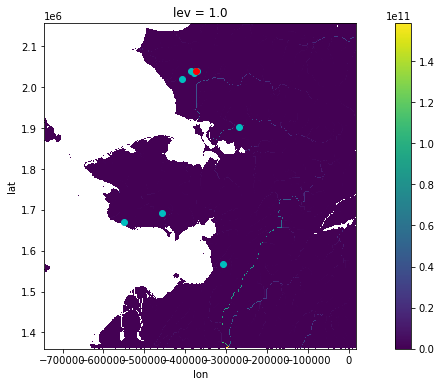

In [65]:
fig, ax = plt.subplots(figsize=(14,6))

qsum.where(qsum>0).plot(vmin=0,ax=ax)
stnproj.plot(ax=ax,c='c')
stnproj.where(stnproj.site_no == stnproj.site_no[i]).plot(ax=ax,c='r')

Station # = 15746990


(-377500.0, -371500.0)

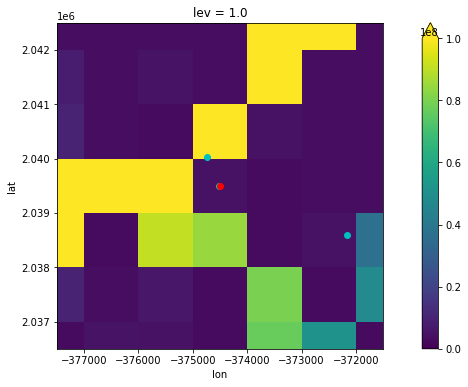

In [66]:
print('Station # = '+ stnproj.iloc[i].site_no)
slow = q.slow.sel(lon=stnproj.iloc[i].geometry.x, lat=stnproj.iloc[i].geometry.y, lev=1.0,method='nearest')
fast = q.fast.sel(lon=stnproj.iloc[i].geometry.x, lat=stnproj.iloc[i].geometry.y, lev=1.0,method='nearest')
# dataframe 
dftest = pd.DataFrame({'x':[slow.lon.values.tolist()], 'y':[slow.lat.values.tolist()]})
# geodataframe
gdftest = gpd.GeoDataFrame(dftest,geometry=gpd.points_from_xy(dftest.x, dftest.y),crs=domains[domain]['mod_proj'])

fig, ax = plt.subplots(figsize=(14,6))

qsum.where(qsum>0).plot(vmin=0,vmax=1e8,ax=ax)
stnproj.plot(ax=ax,c='c')
gdftest.plot(ax=ax,c='r')
#gdftest2.plot(ax=ax,c='g')
plt.ylim([dftest.y.values[0]-3000,dftest.y.values[0]+3000])
plt.xlim([dftest.x.values[0]-3000,dftest.x.values[0]+3000])

In [67]:
yidx = int(np.where(q.lat == slow.lat)[0])
xidx = int(np.where(q.lon == slow.lon)[0])
print('yidx = ', yidx)
print('xidx = ', xidx)

yidx =  679
xidx =  370


Note: need to move the lat down by one pixel to reside in the modeled channel 

(-382500.0, -366500.0)

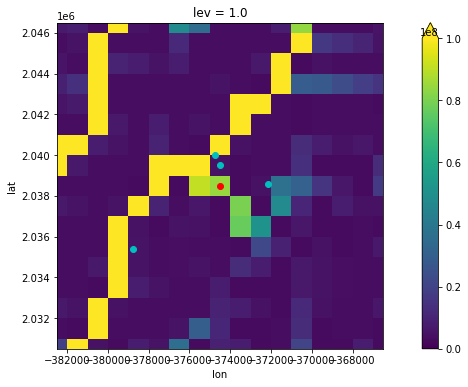

In [68]:
yidx = int(np.where(q.lat == slow.lat)[0]-1)
xidx = int(np.where(q.lon == slow.lon)[0])
# dataframe 
dftest = pd.DataFrame({'x':[q.lon.isel(lon=xidx).values.tolist()], 'y':[q.lat.isel(lat=yidx).values.tolist()]})
# geodataframe
gdftest = gpd.GeoDataFrame(dftest,geometry=gpd.points_from_xy(dftest.x, dftest.y),crs=domains[domain]['mod_proj'])

fig, ax = plt.subplots(figsize=(14,6))

qsum.where(qsum>0).plot(vmin=0,vmax=1e8,ax=ax)
stnproj.plot(ax=ax,c='c')
gdftest.plot(ax=ax,c='r')
#gdftest2.plot(ax=ax,c='g')
plt.ylim([dftest.y.values[0]-8000,dftest.y.values[0]+8000])
plt.xlim([dftest.x.values[0]-8000,dftest.x.values[0]+8000])

In [69]:
print('yidx fixed = ', yidx)
print('xidx fixed = ', xidx)

yidx fixed =  678
xidx fixed =  370


In [70]:
m = folium.Map(tiles='Stamen terrain')
for idx, row in stnproj.iterrows():
    folium.Marker(location=[row['dec_lat_va'], row['dec_long_va']], 
                  icon=folium.Icon(color='blue'),
                  popup="</br> Gage#: {0} </b> Gage name: {1}".format(
                      row['site_no'], row['station_nm'])
                 ).add_to(m)
folium.Marker(location=[gdftest.to_crs('epsg:4326').geometry.y.values[0], gdftest.to_crs('epsg:4326').geometry.x.values[0]], 
              icon=folium.Icon(color='red'),
              popup="</br> Gage#: {0} </b> Gage name: {1}".format(
                  row['site_no'], row['station_nm'])
             ).add_to(m)

# Set the map extent (bounds) to the extent of the sites
m.fit_bounds(m.get_bounds())

basemaps['Google Satellite'].add_to(m)

m

In [117]:
#indicies to save out
xidx8 = np.nan
yidx8 = np.nan

## save data

In [152]:
# from anaylsis above
xidx = [xidx1,xidx2,xidx3,xidx4,xidx5,xidx6,xidx7,xidx8]
yidx = [yidx1,yidx2,yidx3,yidx4,yidx5,yidx6,yidx7,yidx8]

In [153]:
# add x and y idx to metadata
stnproj['xidx'] = xidx
stnproj['yidx'] = yidx
path=flowstnprojcal
stnproj.to_file(path, driver='GeoJSON') 

/nfs/attic/dfh/miniconda/envs/nprb/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
